<a href="https://colab.research.google.com/github/kburns/cism_dedalus_2023/blob/main/lecture_2_intro_to_dedalus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Dedalus -- Burgers & KdV Equations

**Overview:** This notebook provides an introduction to the Dedalus v3 API and walks through setting up and solving the 1D Burgers and KdV equations.

**About Dedalus:** [Dedalus](http://dedalus-project.org) is an open-source Python package for solving partial differential equations (PDEs) using global spectral methods.
These methods provide highly accurate numerical solutions for PDEs with smooth solutions in simple domains like boxes and spheres.
Dedalus implements modern parallel algorithms utilizing sparse polynomial bases, but all with an easy-to-use symbolic interface.
The code is being used in a wide range of fields, often for problems involving fluid dynamics.

**Author:** [Keaton Burns](http://keaton-burns.com)

# Setup

This cell checks if Dedalus is installed and performs some other basic setup.

If Dedalus is not installed and you are using Google Colab, it will automatically be installed.
This may take a few minutes the first time you run the notebook, but subsequent sessions during the next day or so should have the installation cached.
No need to worry about the details -- just execute the cell.

If you are not using Google Colab, follow the installation instructions in the [Dedalus Docs](https://dedalus-project.readthedocs.io/en/latest/pages/installation.html) to install Dedalus locally on your computer.
Installation using conda is typically straightforward for Mac and Linux.
No promises on Windows.
Execute the cell to confirm Dedalus is installed and importable.

In [1]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install cython "mpi4py<4.0" numpy setuptools wheel
        !CC=mpicc pip3 install --no-cache --no-build-isolation http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus already installed :)


# Content

First let's import everything we need to run the rest of the notebook.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)
%matplotlib widget

## 1. Coordinates, Distributors, and Bases

Dedalus uses spectral discretizations to represent fields and solve PDEs. 
These discretizations are specified by selecting spectral bases for the spatial coordinates of a problem. 
The set of coordinates in a problem are used to construct a distributor object that controls how fields and problems are distributed in parallel.

Here we'll go through setting up these objects for a simple 1D problem running in serial.
For more details on other problem types, included distributed parallel simulations, see the official [Dedalus Tutorial 1](https://dedalus-project.readthedocs.io/en/latest/notebooks/dedalus_tutorial_1.html).

### 1.1: Coordinates

The spatial coordinates in a PDE are represented by coordinate objects in Dedalus.
Individual coordinates can be defined using the `Coordinate` class, which is primarily used for 1D problems.
In multiple dimensions, multiple coordinates can be constructed together as a `CoordinateSystem`.
The currently included coordinate systems are:

* `CartesianCoordinates` of any dimension.
* `PolarCoordinates` with azimuth and radius.
* `S2Coordinates` with azimuth and colatitude.
* `SphericalCoordaintes` with azimuth, colatitude, and radius.

Let's create a coordinate object representing our 1D coordinate, which here we will call `x`:

In [3]:
xcoord = d3.Coordinate('x')

### 1.2: Distributors

`Distributor` objects direct the parallel decomposition and transformation of fields, and are needed for all problems, even when running in serial.
To build a distributor, we pass the coordinate or coordinate system of our PDE, specify the datatype of the fields we'll be using, and optionally specify a process mesh for parallelization.

Let's create a distributor with our single coordinate for a problem with real variables.

In [4]:
dist = d3.Distributor(xcoord, dtype=np.float64) # No mesh for serial / automatic parallelization

### 1.3: Bases

Each type of basis in Dedalus is represented by a separate class.
These classes define the corresponding spectral operators as well as transforms between the "grid space" and "coefficient space" representations of functions in that basis.
The most commonly used bases are:

* `RealFourier` for real periodic functions on an interval using cosine & sine modes.
* `ComplexFourier` for complex periodic functions on an interval using complex exponentials.
* `Chebyshev` for functions on an interval.
* `DiskBasis` for functions on a full disk in polar coordinates.
* `AnnulusBasis` for functions on an annulus in polar coordinates.
* `SphereBasis` for functions on the 2-sphere in S2 or spherical coordinates.
* `BallBasis` for functions on a full ball in spherical coordinates.
* `ShellBasis` for functions on a spherical shell in spherical coordinates.

The one-dimensional / Cartesian bases are instantiated with:

* the corresponding coordinate object,
* the number of modes for the basis,
* the coordinate bounds of the basis interval,
* an optional dealiasing scale factor, indiciated how much to pad the included modes when transforming to grid space (3/2 for quadratic nonlinerities).

Let's construct a real Fourier basis over our coordinate, with a specified resolution, domain size, and dealiasing:

In [5]:
# Parameters
Lx = 10
Nx = 1024
dealias = 3/2

# Basis
xbasis = d3.RealFourier(xcoord, size=Nx, bounds=(0, Lx), dealias=dealias)

Each basis has a corresponding coordinate/collocation grid (or grids for multidimensional bases) that can be used for tasks like initializing and plotting fields.
The local grid(s) of a basis can be accessed using the distributor object's `local_grid` method.
This method optionally take a `scale` argument determining the number of points in the grid relative to the number of basis modes.

Initialization and output are often done with the regular (scale 1) grid, while nonlinear computations are internally performed on the grid with the prescribed dealias scale for each basis.

In [6]:
normal_grid = dist.local_grid(xbasis, scale=1)
dealiased_grid = dist.local_grid(xbasis, scale=3/2)
print('Regular grid size:', normal_grid.size)
print('Dealiased grid size:', dealiased_grid.size)

Regular grid size: 1024
Dealiased grid size: 1536


## 2. Fields and Operators


Dedalus uses field and operator abstractions to implement a symbolic algebra system for representing and evaluating mathematical expressions and PDEs.
For more details, see the official [Dedalus Tutorial 2](https://dedalus-project.readthedocs.io/en/latest/notebooks/dedalus_tutorial_2.html).

### 2.1: Fields

`Field` objects in Dedalus represent scalar-valued fields defined over a set of bases (or a "domain").
For multidimensional problems, vector and tensor valued fields can also be constructed using the `VectorField` and `TensorField` clases.

Let's construct a field using our 1D basis:

In [7]:
u = dist.Field(name='u', bases=xbasis)

Field objects have internal methods for transforming their data between grid (`'g'`) and coefficeint (`'c'`) space representations.
The field's values can be assigned and retrieved by indexing a field with these strings.

Let's set the grid-space values of our field to some periodic function of `x`:

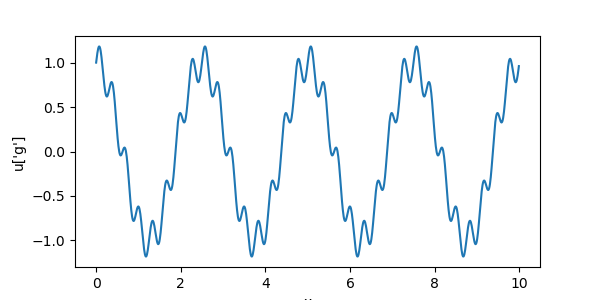

In [8]:
x = dist.local_grid(xbasis)
k0 = 2 * np.pi / Lx
u.change_scales(1) # Set values on regular grid
u['g'] = np.cos(4*k0*x) + 0.2*np.sin(32*k0*x)

plt.figure(figsize=(6, 3))
plt.plot(x, u['g'])
plt.xlabel('x')
plt.ylabel("u['g']");

We can convert a field to spectral coefficients by requesting the field's data in coefficient space.
This internally triggers an in-place spectral transform on the field's data.
For the `RealFourier` basis, the coefficients are the interleaved real-valued coefficients of the cosine and (negative) sine coefficients.
The frequencies are relative to the fundamental frequency of the domain.

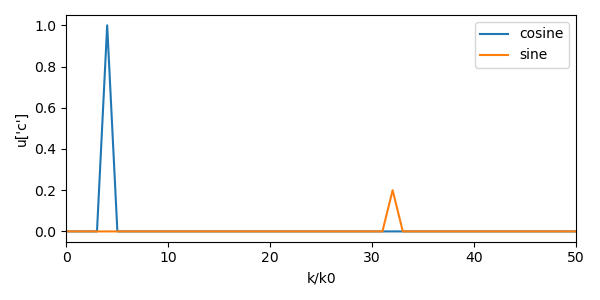

In [9]:
plt.figure(figsize=(6, 3))
plt.plot(u['c'][0::2], label='cosine')
plt.plot(-u['c'][1::2], label='sine')
plt.xlabel('k/k0')
plt.ylabel("u['c']")
plt.xlim(0, 50)
plt.legend()
plt.tight_layout()

### 2.2: Operators

Mathematical operations on fields, including arithmetic, differentiation, integration, and interpolation, are represented by `Operator` classes.
An instance of an operator class represents a specific mathematical expression, and provides an interface for the deferred evaluation of that expression with respect to it's potentially evolving arguments.

Arithmetic operations between fields, or fields and scalars, are produced simply using Python's infix operators for arithmetic and numpy univeral functions:

In [10]:
v_op = np.exp(1 + 2*u)
print(v_op)

exp(C(1) + 2*u)


The object we get is not another field, but an operator object representing the prescibed mathematical operation.
We can plot the operator as a symbolic graph using a helper function from `dedalus.tools`:

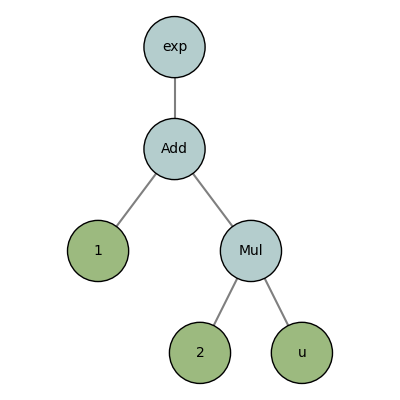

In [11]:
from dedalus.tools.plot_op import plot_operator
plot_operator(v_op, figsize=4, fontsize=10, opsize=0.3)
plt.tight_layout()

To actually compute this operation, we use the `evaluate` method of the operator, which returns a new field with the result.
The dealias scale factors set during basis instantiation are used for the evaluation of all operators, so we need to change the field back to the regular scales to plot it.

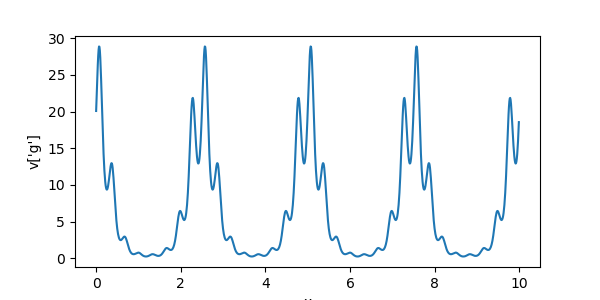

In [12]:
v = v_op.evaluate()
v.change_scales(1) # View values on regular grid

# Plot grid values
plt.figure(figsize=(6, 3))
plt.plot(x, v['g'])
plt.xlabel('x')
plt.ylabel("v['g']");

Partial derivatives in Cartesian coordinates can be taken using the `Differentiate` operator. 
Definite integrals, domain averages, and pointwise interpolation are also available using the `Integrate`, `Average`, and `Interpolate` operators.

For example, we can compute the average value of `v` using these methods, as well as the average value of the derivative of `v` (what should this be, by periodicity?):

In [13]:
ave = lambda a: d3.Average(a)
dx = lambda a: d3.Differentiate(a, xcoord)

print(ave(v).evaluate()['g'])
print(ave(dx(v)).evaluate()['g'])

[6.44690718]
[0.]


For multidimensional problems, it's more common to use the built in vector calculus operators, including:

* `Gradient` for arbitrary fields,
* `Divergence` for arbitrary vector/tensor fields,
* `Curl` for vector fields,
* `Laplacian`, defined as the divergence of the gradient, for arbitrary fields,

and others for manipulating tensor components.

## 3. Problems and Solvers

Dedalus symbolically solves initial value, boundary value, and eigenvalue problems using corresponding Problem and Solver classes for each of these.
Here we will go over solving a simple 1D IVP.
For more details on other problem types, see the official [Dedalus Tutorial 3](https://dedalus-project.readthedocs.io/en/latest/notebooks/dedalus_tutorial_2.html).

### 3.1 Problems

Dedalus standardizes the formulation of all initial value problems by taking systems of symbolically specified equations and boundary conditions specified in the following generic form:

$$\mathcal{M} \cdot \partial_t \mathcal{X} + \mathcal{L} \cdot \mathcal{X} = \mathcal{F}(\mathcal{X}, t)$$

where $\mathcal{M}$ and $\mathcal{L}$ are matrices of linear differential operators, $\mathcal{X}$ is a state vector of the unknown fields, $\mathcal{F}$ is a vector of general nonlinear expressions.

The left-hand side (LHS) of the equations must be first-order in temporal derivatives and linear in the problem variables.
The right-hand side (RHS) of the equations may contain nonlinear and time-dependent terms, but no temporal derivatives.

To create a problem object, you must provide a list of the field variables to be solved for.
You can pass a dictionary via the `namespace` argument during problem instantiation to make substitutions (operators or functions) available when parsing the equations later on.
Typically we suggest passing `locals()` here, to make all script-level definitions available inside the problem.

Equations can then be entered as pairs of operator expressions like `(LHS, RHS)` or as strings like `"LHS = RHS"`.
In addition to the substitutions available through the provided `namespace`, the string parsing recognizes all the built-in operators as well as abbreviations for some of them.

Let's start setting up Burger's equation on the domain we've been using so far:

$$\partial_t u + u \partial_x u = a \partial_x^2 u$$

In [14]:
# Parameters
a = 2e-3

# Problem
problem = d3.IVP([u], namespace=locals())
problem.add_equation("dt(u) - a*dx(dx(u)) = - u*dx(u)");

### 3.2 Solvers

Each problem type (IVP, EVP, LBVP, and NLBVP) has a corresponding solver class that actually performs the solution steps for a corresponding problem.
Solvers are simply built using the `problem.build_solver` method.

For IVPs, we select a timestepping method when building the solver.
Several multistep and Runge-Kutta IMEX schemes are available (see the list in the [timesteppers module](../autoapi/dedalus/core/timesteppers/index.html)), and can be selected by name.

In [15]:
timestepper = d3.SBDF2
solver = problem.build_solver(timestepper)

2024-09-27 10:12:19,583 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+02/s


For IVPs, stopping criteria for halting time evolution are specified by setting the `solver.stop_iteration`, `solver.stop_wall_time` (seconds since solver instantiation), and/or `solver.stop_sim_time` attributes.  

Let's stop at $t = 10$ in simulation units:

In [16]:
stop_sim_time = 10
solver.stop_sim_time = stop_sim_time

For IVPs and nonlinear BVPs, the initial conditions are set by directly modifying the state variable data before running a simulation.

In [17]:
# Initial conditions
n = 20
u.change_scales(1) # Set values on regular grid
u['g'] = np.log(1 + np.cosh(n)**2/np.cosh(n*(x-0.2*Lx))**2) / (2*n)

IVPs are iterated using the `solver.step` method with a provided timestep.
The logic controlling the main-loop of a Dedalus IVP simulation occurs explicitly in the simulation script.
The `solver.proceed` property will change from `True` to `False` once any of the specified stopping criteria have been met.
Let's timestep our problem until the halting condition is reached, copying the grid values of `u` every few iterations.
This should take just a few seconds to run.

In [18]:
# Main loop
timestep = 2e-3
u.change_scales(1)
u_list = [np.copy(u['g'])]
t_list = [solver.sim_time]
while solver.proceed:
    solver.step(timestep)
    if solver.iteration % 500 == 0:
        logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
    if solver.iteration % 25 == 0:
        u.change_scales(1)
        u_list.append(np.copy(u['g']))
        t_list.append(solver.sim_time)

2024-09-27 10:12:19,754 __main__ 0/1 INFO :: Iteration=500, Time=1.000000e+00, dt=2.000000e-03
2024-09-27 10:12:19,852 __main__ 0/1 INFO :: Iteration=1000, Time=2.000000e+00, dt=2.000000e-03
2024-09-27 10:12:19,951 __main__ 0/1 INFO :: Iteration=1500, Time=3.000000e+00, dt=2.000000e-03
2024-09-27 10:12:20,056 __main__ 0/1 INFO :: Iteration=2000, Time=4.000000e+00, dt=2.000000e-03
2024-09-27 10:12:20,167 __main__ 0/1 INFO :: Iteration=2500, Time=5.000000e+00, dt=2.000000e-03
2024-09-27 10:12:20,289 __main__ 0/1 INFO :: Iteration=3000, Time=6.000000e+00, dt=2.000000e-03
2024-09-27 10:12:20,394 __main__ 0/1 INFO :: Iteration=3500, Time=7.000000e+00, dt=2.000000e-03
2024-09-27 10:12:20,520 __main__ 0/1 INFO :: Iteration=4000, Time=8.000000e+00, dt=2.000000e-03
2024-09-27 10:12:20,621 __main__ 0/1 INFO :: Iteration=4500, Time=9.000000e+00, dt=2.000000e-03
2024-09-27 10:12:20,720 __main__ 0/1 INFO :: Iteration=5000, Time=1.000000e+01, dt=2.000000e-03
2024-09-27 10:12:20,721 solvers 0/1 INFO 

Now we can make a space-time plot of the solution:

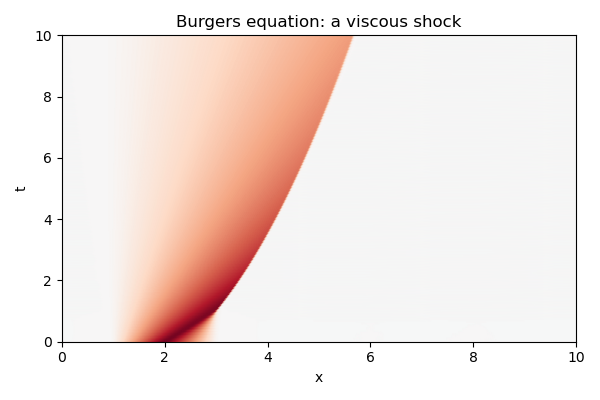

In [19]:
# Plot
plt.figure(figsize=(6, 4))
plt.pcolormesh(x.ravel(), np.array(t_list), np.array(u_list), cmap='RdBu_r', shading='gouraud', rasterized=True, clim=(-1, 1))
plt.xlim(0, Lx)
plt.ylim(0, stop_sim_time)
plt.xlabel('x')
plt.ylabel('t')
plt.title(f'Burgers equation: a viscous shock')
plt.tight_layout()

We see the solution forms a shock that is regulated by viscosity.
We might worry that spectral methods don't handle shocks well, but that's only if their physical regulation is not well resolved.
Lets zoom in on the shock at a particular time and see if it's resolved:

(4.2, 4.7)

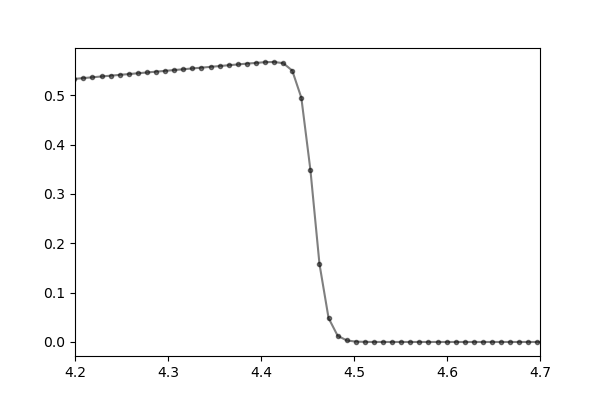

In [20]:
# Plot
plt.figure(figsize=(6, 4))
plt.plot(x.ravel(), u_list[100], '.-k', alpha=0.5)
plt.xlim(4.2, 4.7)

This looks good!

The real power of Dedalus is the flexibility that this system provides for rapid model iteration and exploring different equations.
So let's modify our example by replacing viscosity with a dispersive term, and solve the KdV equation instead of Burgers:

$$\partial_t u + u \partial_x u = b \partial_x^3 u$$

In [21]:
# Parameters
b = 1e-4

# Problem
problem = d3.IVP([u], namespace=locals())
problem.add_equation("dt(u) - b*dx(dx(dx(u))) = - u*dx(u)")

# Initial conditions
n = 20
u['g'] = np.log(1 + np.cosh(n)**2/np.cosh(n*(x-0.2*Lx))**2) / (2*n)

# Solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

# Main loop
u.change_scales(1)
u_list = [np.copy(u['g'])]
t_list = [solver.sim_time]
while solver.proceed:
    solver.step(timestep)
    if solver.iteration % 500 == 0:
        logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
    if solver.iteration % 25 == 0:
        u.change_scales(1)
        u_list.append(np.copy(u['g']))
        t_list.append(solver.sim_time)

2024-09-27 10:12:23,256 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.1e+01/s
2024-09-27 10:12:23,381 __main__ 0/1 INFO :: Iteration=500, Time=1.000000e+00, dt=2.000000e-03
2024-09-27 10:12:23,500 __main__ 0/1 INFO :: Iteration=1000, Time=2.000000e+00, dt=2.000000e-03
2024-09-27 10:12:23,622 __main__ 0/1 INFO :: Iteration=1500, Time=3.000000e+00, dt=2.000000e-03
2024-09-27 10:12:23,743 __main__ 0/1 INFO :: Iteration=2000, Time=4.000000e+00, dt=2.000000e-03
2024-09-27 10:12:23,864 __main__ 0/1 INFO :: Iteration=2500, Time=5.000000e+00, dt=2.000000e-03
2024-09-27 10:12:23,984 __main__ 0/1 INFO :: Iteration=3000, Time=6.000000e+00, dt=2.000000e-03
2024-09-27 10:12:24,122 __main__ 0/1 INFO :: Iteration=3500, Time=7.000000e+00, dt=2.000000e-03
2024-09-27 10:12:24,243 __main__ 0/1 INFO :: Iteration=4000, Time=8.000000e+00, dt=2.000000e-03
2024-09-27 10:12:24,362 __main__ 0/1 INFO :: Iteration=4500, Time=9.000000e+00, dt=2.000000e-03
2024-

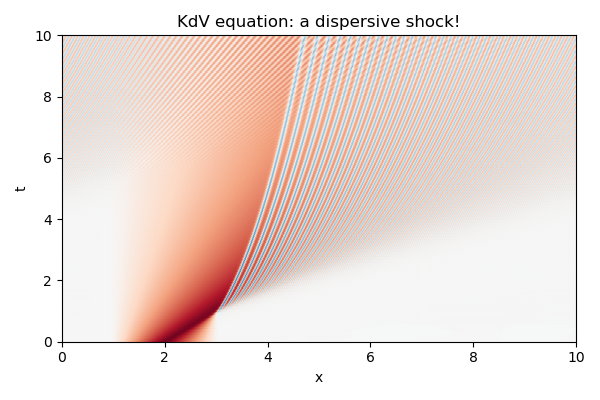

In [22]:
# Plot
plt.figure(figsize=(6, 4))
plt.pcolormesh(x.ravel(), np.array(t_list), np.array(u_list), cmap='RdBu_r', shading='gouraud', rasterized=True, clim=(-1, 1))
plt.xlim(0, Lx)
plt.ylim(0, stop_sim_time)
plt.xlabel('x')
plt.ylabel('t')
plt.title(f'KdV equation: a dispersive shock!')
plt.tight_layout()